# SVI with Mixture of Gaussian posterior - bimodal toy dataset

In this notebook, stochastic VI is implemented in pytorch. <br />
The forms of prior and approximate posterior are assumed and predefined. <br />
The standard deviation of likelihood is predifined, 
however likelihood `mean` is computed using an observed toy dataset. 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
softplus = torch.nn.Softplus()
softmax = torch.nn.Softmax(dim=0)
num_samples = [100, 100]  # Number of samples
num_components = 2
num_steps = 5000

## Sampling
`gaussian_sample` function samples from a gaussian with reparameterization.<br />


In [3]:
def gaussian_sample(mean, std, num_samples, D=1):
    eps = torch.randn(size=(num_samples, D))
    z = eps * std + mean
    return z

`log_gmm` and `log_gaussian` compute log pdf of gmm and gaussian ditributions respectively. 

In [4]:
def log_gaussian(x, mean, std):
    return -0.5 * torch.log(2 * np.pi * std ** 2) - (0.5 * (1 / (std ** 2)) * (x - mean) ** 2)

def log_gmm(x, means, stds, log_pais):
    comp_log_dens = torch.stack([log_gaussian(x, mu, std) for (mu, std) in zip(means, stds)]).T
    log_weights = log_normalize(log_pais)
    return torch.logsumexp(comp_log_dens + log_weights, axis=-1, keepdims=False)

def log_normalize(x):
    return x - torch.logsumexp(x, 0)


In [5]:
import math
def gaussian(x, mean, std):
    return (1 / torch.sqrt(torch.FloatTensor([2*math.pi])*std**2)) * torch.exp(-((x - mean) ** 2.) / (2 * std**2))

def gmm(x, means, variances, pais):
    return sum([pai * gaussian(x, mu, var) for (pai, mu, var) in zip(pais, means, variances)])

## Generating Data
We generate a bimodal dataset.

In [6]:
def create_bimodal_data(w1, w2, std1, std2, pai, num_samples, low=-50, high=50):
    # generate data:
    # p(t|w, x) = a * N(t; w1*x, std1) + (1-a) * N(t; w2*x, std2)
    #         (1) sample x_i
    #         (2) compute y_i from GMM
    x = np.random.uniform(low=-50, high=50, size=num_samples)
    samples = torch.cat([gaussian_sample(mean, std, num_samples)
                         for mean, std in zip(torch.tensor([0., 0.]), 
                                              torch.tensor([std1, std2]))], axis=1)

    samples[:, 0] += torch.tensor(w1 * x)
    samples[:, 1] += torch.tensor(w2 * x)
    weights = torch.tensor([pai, 1-pai])
    ixs = torch.multinomial(weights, num_samples, replacement=True)
    t = torch.stack([samples[i, ix] for i, ix in enumerate(ixs)])
    x = torch.unsqueeze(torch.tensor(x), -1)
    t = torch.unsqueeze(torch.tensor(t), -1)

    return x, t

In [7]:
def create_unimodal_data(num_samples, w, scale, low=-10, high=10):
    x = np.random.uniform(low=low, high=high, size=(num_samples, 1))
    t = w * x + np.random.normal(size=(num_samples, 1), scale=scale)
    x = torch.tensor(x)
    t = torch.tensor(t)
    return x, t

In [8]:
def create_bimodal_data2(w1, w2, std1, std2, pai, num_samples, low=-50, high=50):
    x1, t1 = create_unimodal_data(num_samples, w1, std1)
    x2, t2 = create_unimodal_data(num_samples, w2, std2)
    
    samples = torch.cat([x1, x2], axis=1)
    targets = torch.cat([t1, t2], axis=1)

    weights = torch.tensor([pai, 1-pai])
    ixs = torch.multinomial(weights, num_samples, replacement=True)
    
    x = torch.stack([samples[i, ix] for i, ix in enumerate(ixs)])
    t = torch.stack([targets[i, ix] for i, ix in enumerate(ixs)])
    
    x = torch.unsqueeze(x, -1)
    t = torch.unsqueeze(t, -1)
    
    return x, t

/Users/farzaneh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


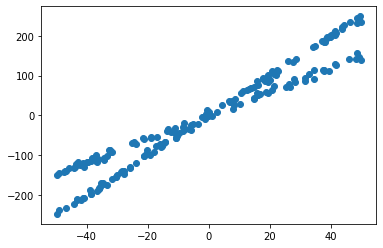

In [9]:
w1 = 3.
w2 = 5.
std1 = 5.
std2 = 5.
pai = .5
x, t = create_bimodal_data(w2, w1, std2, std1, pai, 200)
# x, t = create_unimodal_data(200, 3.8, 4.6, low=-10, high=10)

plt.scatter(x, t)

Lets assume our approximate posterior, `q`,  is a mixture of Gaussians with two components,
our prior is a Gaussian and likelihood is also a mixture of Gaussians.


In [10]:
q_means = torch.nn.Parameter(torch.tensor([2., 4.]), requires_grad=True)
q_stds = torch.nn.Parameter(torch.tensor([1.8, 1.8]), requires_grad=True)
q_log_pais = torch.nn.Parameter(torch.log(torch.tensor([.5, .5])), requires_grad=True)
q_fn = lambda t: log_gmm(t, q_means, softplus(q_stds), q_log_pais)

In [11]:
likelihood_stds = torch.tensor([std1, std2])
likelihood_log_pais = torch.log(torch.tensor([pai, 1-pai]))

In [12]:
p_means = torch.tensor([-3.])
p_stds = torch.tensor([10.])
p_log_pais = torch.log(torch.tensor([1.]))
p_fn = lambda t: log_gmm(t, p_means, softplus(p_stds), p_log_pais)

We can plot the log likelihood.

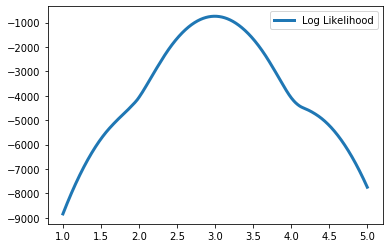

In [13]:
wn = torch.arange(1., 5., 0.0001)
log_likelihood= torch.sum(log_gmm(t, [wn*x, (wn+(w2-w1))*x], likelihood_stds, likelihood_log_pais), 1)
log_prior = p_fn(wn)

plt.plot(wn, log_likelihood, linewidth=3, label="Log Likelihood")

plt.legend()
plt.show()

In [14]:
def compute_elbo(x, t):
    elbo = 0
    for c in range(2):
        # c = torch.randint(0, 2, [1]) ## we can replace the loop over comps with this line to sample the component
        z = gaussian_sample(q_means[c], softplus(q_stds[c]), num_samples[c])
        
        q_likelihood = torch.mean(q_fn(z))
        prior = torch.mean(p_fn(z))
        log_likelihood = torch.mean(torch.sum(log_gmm(t,  [z.T * x, (z.T + (w2-w1)) * x], likelihood_stds,
                        likelihood_log_pais), 1))
        elbo_c = q_likelihood - prior - log_likelihood
        elbo += elbo_c * softmax(q_log_pais)[c]
    return elbo

# Optimizer
We define an optimizer, and pass the variables that we intend to optimize. 

In [15]:
optimizer = torch.optim.Adam([
    {'params': [q_log_pais, q_means, q_stds], 'lr': 0.1}])

## Training

In [16]:
for step in range(num_steps):
    loss = compute_elbo(x, t)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if step % 250 == 0:
        print('Step:{} Loss: {:.6f}, '
              'means:{}, '
              'stds:{}, '
              'pais:{}'
              .format(step, loss.item(), q_means.data.numpy(), 
                      softplus(q_stds).data.numpy(),
                      softmax(q_log_pais).data.numpy())
             )

Step:0 Loss: 11901.956256, means:[2.1 3.9], stds:[1.8677859 1.8677859], pais:[0.54983395 0.45016602]
Step:250 Loss: 762.004948, means:[2.9973    2.9902003], stds:[0.12448654 0.05412815], pais:[0.05314463 0.9468553 ]
Step:500 Loss: 751.893353, means:[2.9942586 3.0007944], stds:[0.1091868 0.0310031], pais:[0.01823814 0.9817618 ]
Step:750 Loss: 750.850279, means:[2.9952028 2.989749 ], stds:[0.10216085 0.0230154 ], pais:[0.01012686 0.9898732 ]
Step:1000 Loss: 750.743839, means:[2.9977624 2.9881747], stds:[0.09761116 0.01883618], pais:[0.00676584 0.9932341 ]
Step:1250 Loss: 749.982896, means:[2.9957066 2.9917884], stds:[0.09417125 0.01630913], pais:[0.0049436 0.9950564]
Step:1500 Loss: 749.832647, means:[2.9959466 2.9891536], stds:[0.09140789 0.01467613], pais:[0.00382522 0.9961748 ]
Step:1750 Loss: 749.847007, means:[2.997102  2.9975863], stds:[0.08903169 0.01360767], pais:[0.00306057 0.9969394 ]
Step:2000 Loss: 749.760233, means:[2.994671 2.999148], stds:[0.08695796 0.01285381], pais:[0.0

## Plotting

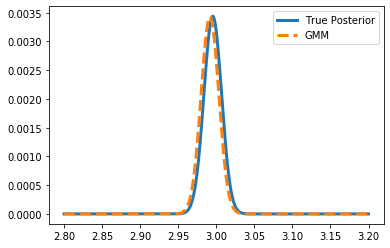

In [18]:
wn = torch.arange(2.8, 3.2 , 0.0001)
log_likelihood = torch.sum(log_gmm(t, [wn * x, (wn+(w2-w1))*x],
                                   likelihood_stds, likelihood_log_pais), 1)
log_prior = p_fn(wn)

log_true_posterior = log_likelihood + log_prior
log_true_posterior = log_true_posterior - torch.max(log_true_posterior)
true_posterior = torch.exp(log_true_posterior) / torch.sum(
    torch.exp(log_true_posterior))

plt.plot(wn, true_posterior, linewidth=3, label="True Posterior")

posterior = torch.exp(q_fn(wn))
plt.plot(wn, posterior.clone().detach() / torch.sum(posterior.clone().detach()), '--',
         linewidth=3, label="GMM")
# plt.plot(wn, torch.exp(log_likelihood))
plt.legend()
plt.show()